In [1]:
# --------------------
# Imports and Setup
# --------------------

# Next-Level Stochastic Modeling: Bayesian Regimes, Kalman Filtering, Stochastic Volatility & Deep Sequence Models

## Imports & Global Configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import inv
from scipy.signal import lfilter
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

np.random.seed(42)

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


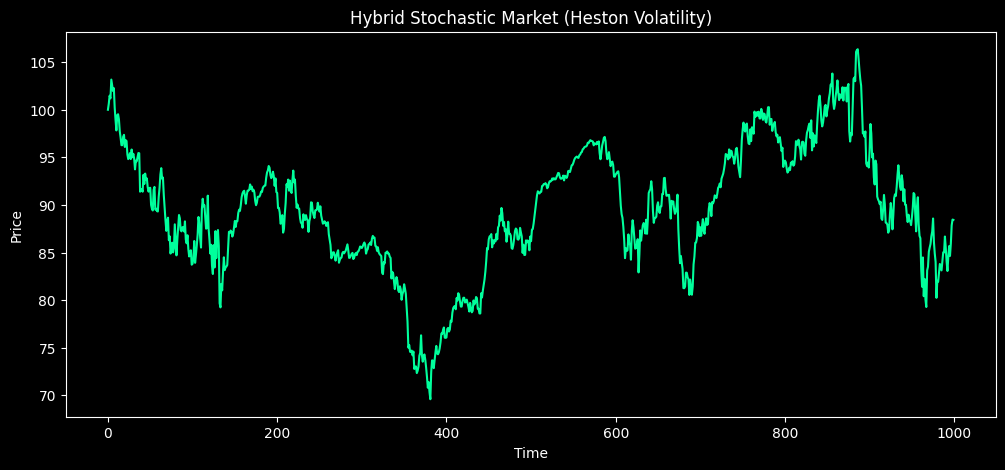

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
Model is not converging.  Current: 3098.889425400838 is not greater than 3099.1818027312484. Delta is -0.29237733041054526


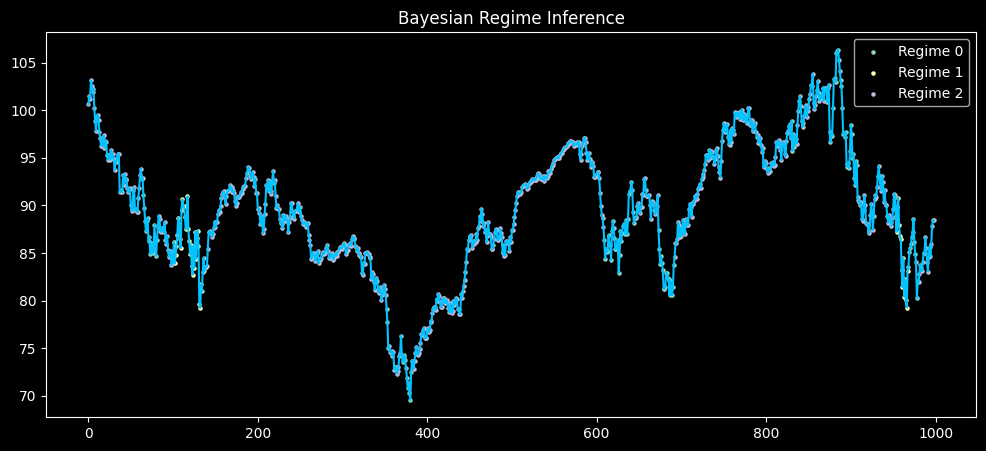

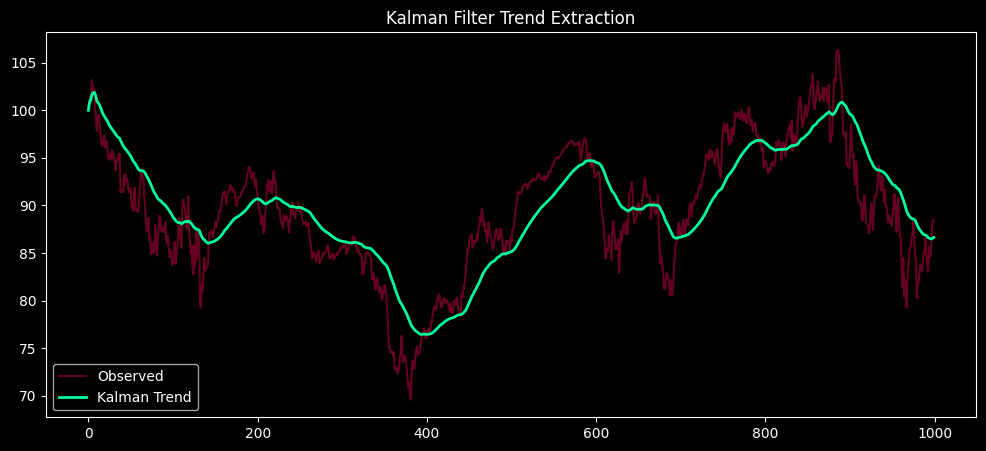

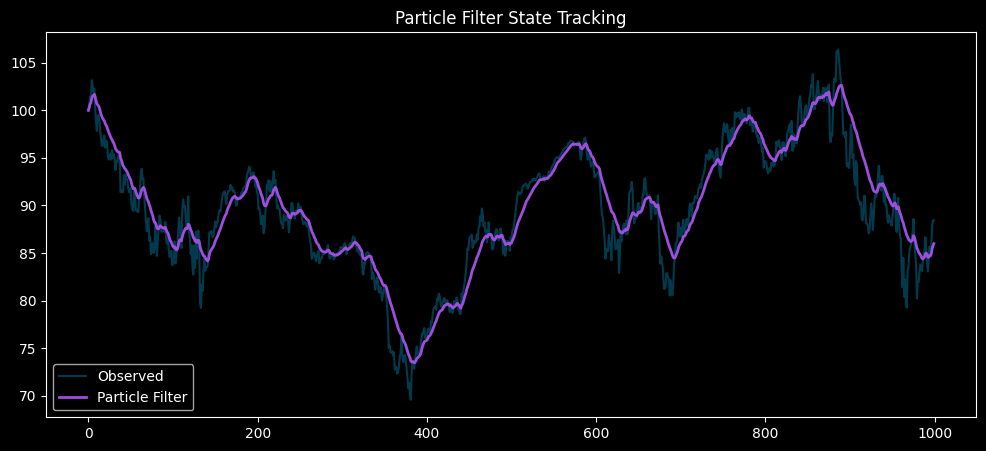

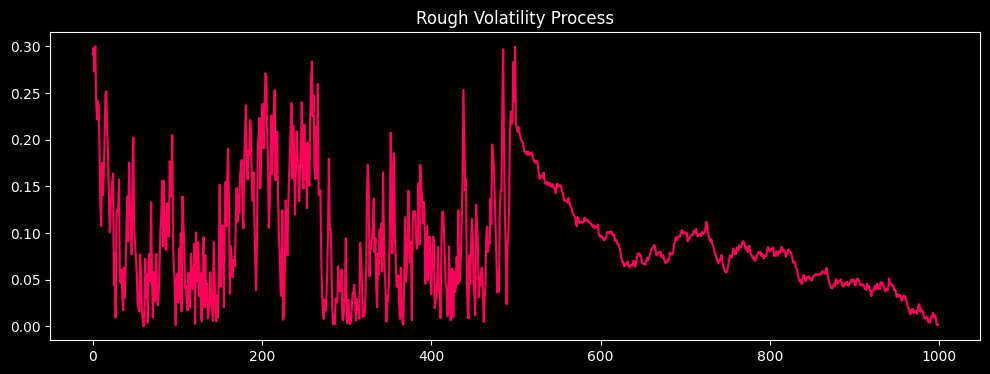

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7668 - loss: 0.9388
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7998 - loss: 0.6719
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7998 - loss: 0.6191
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7998 - loss: 0.6147
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7998 - loss: 0.6167
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7998 - loss: 0.6139
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7998 - loss: 0.6139
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7998 - loss: 0.6176
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7998 - loss: 0.6223
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7998 - loss: 0.6125
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


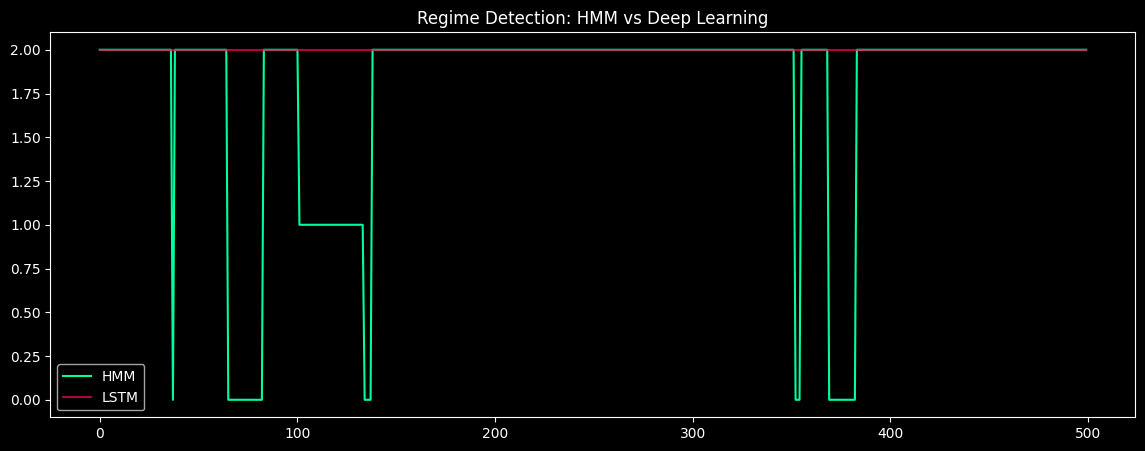

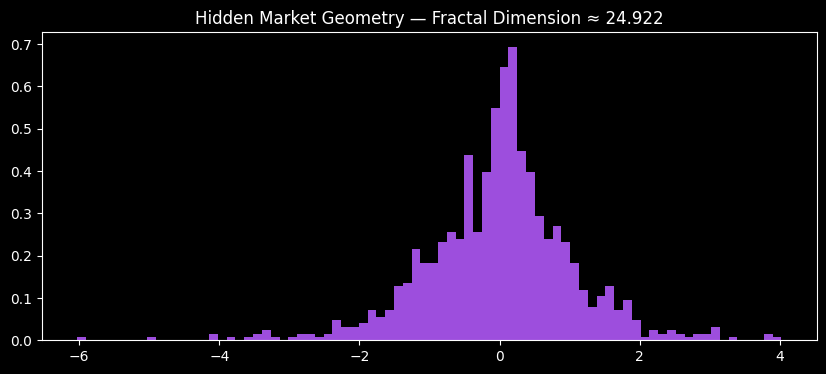

In [3]:
# ----------------------------
# Advanced Stochastic Methods
# ----------------------------

## Synthetic Market Generator

T = 1000
dt = 1/252
mu = 0.07
sigma0 = 0.25
kappa = 3.0
theta = 0.04
xi = 0.6
rho = -0.7

S = np.zeros(T)
v = np.zeros(T)
S[0], v[0] = 100, theta

for t in range(1, T):
    z1, z2 = np.random.randn(), np.random.randn()
    z2 = rho*z1 + np.sqrt(1-rho**2)*z2

    v[t] = np.abs(v[t-1] + kappa*(theta - v[t-1])*dt + xi*np.sqrt(v[t-1]*dt)*z2)
    S[t] = S[t-1] * np.exp((mu - 0.5*v[t])*dt + np.sqrt(v[t]*dt)*z1)

plt.figure(figsize=(12,5))
plt.plot(S, color=STONKS_GREEN)
plt.title("Hybrid Stochastic Market (Heston Volatility)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

## Bayesian Hidden Markov Model (Regime Inference)

returns = np.diff(np.log(S))
X = returns.reshape(-1,1)

hmm = GaussianHMM(n_components=3, covariance_type='full', n_iter=300)
hmm.fit(X)

hidden_states = hmm.predict(X)

plt.figure(figsize=(12,5))
plt.plot(S[1:], color=STONKS_BLUE)
for i in range(3):
    plt.scatter(np.where(hidden_states==i), S[1:][hidden_states==i], s=5, label=f'Regime {i}')
plt.legend()
plt.title("Bayesian Regime Inference")
plt.show()

## Kalman Filter (Linear State Estimation)

def kalman_filter(z, Q=1e-5, R=0.01):
    n = len(z)
    xhat = np.zeros(n)
    P = np.zeros(n)

    xhat[0], P[0] = z[0], 1

    for t in range(1,n):
        xhat_minus = xhat[t-1]
        P_minus = P[t-1] + Q
        K = P_minus / (P_minus + R)
        xhat[t] = xhat_minus + K*(z[t] - xhat_minus)
        P[t] = (1-K)*P_minus
    return xhat

kf_est = kalman_filter(S)

plt.figure(figsize=(12,5))
plt.plot(S, alpha=0.4, label='Observed', color=STONKS_RED)
plt.plot(kf_est, linewidth=2, label='Kalman Trend', color=STONKS_GREEN)
plt.legend()
plt.title("Kalman Filter Trend Extraction")
plt.show()

## Particle Filtering (Nonlinear Regime Tracking)

def particle_filter(z, N=2000):
    particles = np.random.normal(z[0], 1, N)
    weights = np.ones(N)/N
    estimates = []

    for obs in z:
        particles += np.random.normal(0,0.1,N)
        likelihood = norm.pdf(obs, particles, 0.5)
        weights *= likelihood
        weights += 1e-300
        weights /= np.sum(weights)
        idx = np.random.choice(np.arange(N), size=N, p=weights)
        particles = particles[idx]
        weights.fill(1/N)
        estimates.append(np.mean(particles))
    return np.array(estimates)

pf_est = particle_filter(S)

plt.figure(figsize=(12,5))
plt.plot(S, alpha=0.3, label='Observed', color=STONKS_BLUE)
plt.plot(pf_est, linewidth=2, label='Particle Filter', color=STONKS_PURP)
plt.legend()
plt.title("Particle Filter State Tracking")
plt.show()

## Rough Volatility Modeling

def rough_vol(T, H=0.1, sigma=0.3):
    increments = np.random.randn(T)
    kernel = np.arange(1,T+1)**(H-0.5)
    rv = np.convolve(increments, kernel, mode='same')
    return sigma*np.abs(rv/np.max(np.abs(rv)))

rv = rough_vol(T)

plt.figure(figsize=(12,4))
plt.plot(rv, color=STONKS_RED)
plt.title("Rough Volatility Process")
plt.show()

## Deep Learning Regime Classification (LSTM)

window = 30
X_dl, y_dl = [], []

for i in range(window, len(returns)):
    X_dl.append(returns[i-window:i])
    y_dl.append(hidden_states[i])

X_dl = np.array(X_dl)
y_dl = np.array(y_dl)

X_dl = X_dl.reshape((X_dl.shape[0], X_dl.shape[1], 1))

model = Sequential([
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_dl, y_dl, epochs=10, batch_size=64, verbose=1)

## Unified Regime Signal Comparison

plt.figure(figsize=(14,5))
plt.plot(hidden_states[:500], label='HMM', color=STONKS_GREEN)
plt.plot(np.argmax(model.predict(X_dl[:500]),axis=1), alpha=0.7, label='LSTM', color=STONKS_RED)
plt.title("Regime Detection: HMM vs Deep Learning")
plt.legend()
plt.show()

## Grand Finale — Hidden Market Structure
# Surprise quantitative structure discovery

def fractal_dimension(ts):
    N = len(ts)
    L = np.sum(np.abs(np.diff(ts)))
    d = np.log(N)/np.log(N/L)
    return d

fd = fractal_dimension(S)

plt.figure(figsize=(10,4))
plt.hist(np.diff(S), bins=80, density=True, color=STONKS_PURP)
plt.title(f"Hidden Market Geometry — Fractal Dimension ≈ {fd:.3f}")
plt.show()